In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# **Основное задание **

Я загрузил необходимые библиотеки и приступаю к созданию программы 

In [2]:
#Импортируем файл в формате excel по средствам библиотеки pandas

df = pd.read_excel('/kaggle/input/nfactorial/Names.xlsx')
df = df.astype(str) 

#Конвертируем его в лист, добавляем символы в начало и конец

names_list = df['x'].values.tolist()
mylist = [s + '$' for s in names_list]
mylist = ["^" + s for s in mylist]

#Создаем один большой лист "list_bigram" со всеми биграмами

all_words = [] 
list_bigram = []
for i in range(len(mylist) - 1):
    all_words = list(mylist[i])
    for i in range(len(all_words)-1):
        list_bigram.append(f'{all_words[i]}{all_words[i+1]}')

# **Таблица**

In [3]:
#Обратно кенвертируем его в dataframe для более легкой работы с таблицами 

import os
df = pd.DataFrame(list_bigram)
count = df[0].value_counts()
count = count.apply(lambda x: x*100/count.values.sum())
print(f"Таблица вероятности каждого биграма в процентах: {os.linesep}{count}")

Таблица вероятности каждого биграма в процентах: 
n$    2.964408
a$    2.910494
an    2.383624
^a    1.933024
e$    1.745858
        ...   
pm    0.000438
xn    0.000438
sq    0.000438
kf    0.000438
tb    0.000438
Name: 0, Length: 628, dtype: float64


# **Бонусное задание: постройка графика**

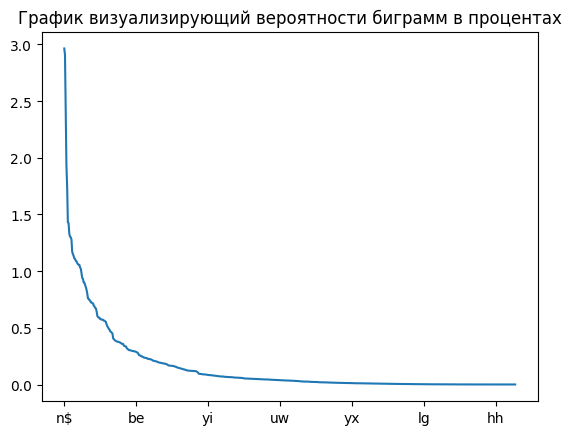

In [4]:
count.plot(y=0, use_index=True)
plt.title('График визуализирующий вероятности биграмм в процентах')
plt.show()


# Создаем функцию генерации нового имени

In [5]:
import random

def generate_function():
    
    name = []
    first_letter = set('^')

    for i in range(len(list_bigram)-1):
            random_bigram = random.choice(list_bigram)
            if first_letter & set(random_bigram):
                name.append(random_bigram)
                break
            else:
                pass

    last_letter = set('$')

    for i in range(len(list_bigram)-1):
            random_bigram = random.choice(list_bigram)
            if last_letter & set(random_bigram):
                name.append(random_bigram)
                break
            elif first_letter & set(random_bigram):
                continue
            else: 
                name.append(random_bigram)
            
    name = "".join([str(i) for i in name])
    print(f'ваше новое имя: {name}')

# Проверка функции

In [6]:
# Я оставил знаки ^, $ для того что бы было видно что функция правильно работает
generate_function()

ваше новое имя: ^dthinsin$


# Бонусное задание: использование и оптимизирование с помощью библиотеки pytorch

In [7]:
#Переводим буквы в юникод 
num_word = []
for i in range(len(names_list) - 1):
    no_space = names_list[i]
    num_list = []
    for c in no_space:
        num_list.append((ord(c)-96))
    num_word.append(num_list) 

#Приводим в порядок размерность массивов 
length = max(map(len, num_word))
num_word = np.array([yi+[0]*(length-len(yi)) for yi in num_word])
print(num_word.shape)

(32032, 15)


In [10]:
#и формат данных
num_word_x = np.array(num_word, dtype='float32')
num_word_y = np.array(num_word, dtype='float32')

In [11]:
#Перемещиваем данные в тестовой выборке 
np.take(num_word_y,np.random.permutation(num_word_y.shape[0]),axis=0,out=num_word_y)
num_word_y = np.array(num_word_y, dtype='float32')


In [17]:
#Загружаем необходимые библиотеки Pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [13]:
#Определяем класс датасета
class Name_dataset(Dataset):

    def __init__(self, input_arrays, output_arrays):
        self.input_arrays = torch.from_numpy(num_word_x)
        self.output_arrays = torch.from_numpy(num_word_y)

    def __getitem__(self, index):
         return self.input_arrays[index], self.output_arrays[index]

    def __len__(self):
        return len(self.input_arrays)

In [14]:
dataset = Name_dataset(num_word, num_word)
first_data = dataset[0]
features= first_data

In [15]:
#Проверяем исправность loadera
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=2)
dataiter = iter(train_loader)
data = next(dataiter)
features, labels = data
print(features[0], os.linesep, labels[0])


tensor([ 1.,  1., 18.,  1., 12., 25., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]) 
 tensor([13.,  1.,  4.,  4., 15., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.])


# 2x Бонусное задание: Создать нейронную сеть которая учится на выборке

In [18]:
#Строим архитектуру NN
class ArrayCNN(nn.Module):
    def __init__(self):
        super(ArrayCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
net = ArrayCNN()
net.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [19]:
#Обучаем нейронною сеть, количество эпох и функция потерь не важны, потому что мы просто хотим сгенерировать новые слова 
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        targets = targets.unsqueeze(1)
        targets = targets.cuda()
        inputs = inputs.unsqueeze(1)
        inputs = inputs.cuda()
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for this epoch
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')


Epoch 1, Loss: 30.23842308477505
Epoch 2, Loss: 29.704586459158154


In [20]:
#Генерируем слова в зашифрованном виде 
dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
targets = targets.unsqueeze(1)
targets = targets.cuda()
generated_array = net(targets)
targets

tensor([[[ 4.,  5., 10., 15., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.]]], device='cuda:0')

# Финальный результат

In [21]:
#Расшифровываем слова 
New_word_encoded = generated_array.round().squeeze().tolist()
New_word_encoded = [int(New_word_encoded) for New_word_encoded in New_word_encoded]
New_word = []
for num in New_word_encoded:
    if num > 0:
        New_word.append(chr(num+96))
    else:
        pass
New_word = "".join([str(i) for i in New_word])
print(New_word)
    

jilhfcba
